In [1]:
import os
import re
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
import math
from pathlib import Path
import json
from copy import deepcopy
from dataclasses import dataclass
from types import SimpleNamespace

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals
from numpy.linalg import svd
from scipy.optimize import linprog
from scipy.sparse import csr_matrix
from scipy.sparse import bmat
from scipy.sparse.csgraph import connected_components
from scipy.linalg import eigh
from scipy.optimize import fsolve
from textwrap import dedent
import networkx as nx   
from matplotlib import animation

In [2]:
'''
Try to build scalable networks
'''

'\nTry to build scalable networks\n'

In [3]:
class Neumann(object):

    """
    This class describes the Generalized von Neumann growth model as it was
    discussed in Kemeny et al. (1956, ECTA) and Gale (1960, Chapter 9.5):

    Let:
    n ... number of goods
    m ... number of activities
    A ... input matrix is m-by-n
        a_{i,j} - amount of good j consumed by activity i
    B ... output matrix is m-by-n
        b_{i,j} - amount of good j produced by activity i

    x ... intensity vector (m-vector) with non-negative entries
        x'B - the vector of goods produced
        x'A - the vector of goods consumed
    p ... price vector (n-vector) with non-negative entries
        Bp - the revenue vector for every activity
        Ap - the cost of each activity

    Both A and B have non-negative entries. Moreover, we assume that
    (1) Assumption I (every good which is consumed is also produced):
        for all j, b_{.,j} > 0, i.e. at least one entry is strictly positive
    (2) Assumption II (no free lunch):
        for all i, a_{i,.} > 0, i.e. at least one entry is strictly positive

    Parameters
    ----------
    A : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x n`
    B : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x k`
    """

    def __init__(self, A, B):

        self.A, self.B = list(map(self.convert, (A, B)))
        self.m, self.n = self.A.shape

        # Check if (A, B) satisfy the basic assumptions
        assert self.A.shape == self.B.shape, 'The input and output matrices \
              must have the same dimensions!'
        assert (self.A >= 0).all() and (self.B >= 0).all(), 'The input and \
              output matrices must have only non-negative entries!'

        # (1) Check whether Assumption I is satisfied:
        if (np.sum(B, 0) <= 0).any():
            self.AI = False
        else:
            self.AI = True

        # (2) Check whether Assumption II is satisfied:
        if (np.sum(A, 1) <= 0).any():
            self.AII = False
        else:
            self.AII = True

    def __repr__(self):
        return self.__str__()

    def __str__(self):

        me = """
        Generalized von Neumann expanding model:
          - number of goods          : {n}
          - number of activities     : {m}

        Assumptions:
          - AI:  every column of B has a positive entry    : {AI}
          - AII: every row of A has a positive entry       : {AII}

        """
        # Irreducible                                       : {irr}
        return dedent(me.format(n=self.n, m=self.m,
                                AI=self.AI, AII=self.AII))

    def convert(self, x):
        """
        Convert array_like objects (lists of lists, floats, etc.) into
        well-formed 2D NumPy arrays
        """
        return np.atleast_2d(np.asarray(x))


    def bounds(self):
        """
        Calculate the trivial upper and lower bounds for alpha (expansion rate)
        and beta (interest factor). See the proof of Theorem 9.8 in Gale (1960)
        """

        n, m = self.n, self.m
        A, B = self.A, self.B

        f = lambda α: ((B - α * A) @ np.ones((n, 1))).max()
        g = lambda β: (np.ones((1, m)) @ (B - β * A)).min()

        UB = fsolve(f, 1).item()  # Upper bound for α, β
        LB = fsolve(g, 2).item()  # Lower bound for α, β

        return LB, UB


    def zerosum(self, γ, dual=False):
        """
        Given gamma, calculate the value and optimal strategies of a
        two-player zero-sum game given by the matrix

                M(gamma) = B - gamma * A

        Row player maximizing, column player minimizing

        Zero-sum game as an LP (primal --> α)

            max (0', 1) @ (x', v)
            subject to
            [-M', ones(n, 1)] @ (x', v)' <= 0
            (x', v) @ (ones(m, 1), 0) = 1
            (x', v) >= (0', -inf)

        Zero-sum game as an LP (dual --> beta)

            min (0', 1) @ (p', u)
            subject to
            [M, -ones(m, 1)] @ (p', u)' <= 0
            (p', u) @ (ones(n, 1), 0) = 1
            (p', u) >= (0', -inf)

        Outputs:
        --------
        value: scalar
            value of the zero-sum game

        strategy: vector
            if dual = False, it is the intensity vector,
            if dual = True, it is the price vector
        """

        A, B, n, m = self.A, self.B, self.n, self.m
        M = B - γ * A

        if dual == False:
            # Solve the primal LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(m), -1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(m * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([-M.T, np.ones((n, 1))])
            b_iq = np.zeros((n, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(m), 0]).reshape(1, m + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        else:
            # Solve the dual LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(n), 1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(n * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([M, -np.ones((m, 1))])
            b_iq = np.zeros((m, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(n), 0]).reshape(1, n + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        if res.status != 0 or res.x is None:
            # LP infeasible or error
            return np.nan, None

        # Pull out the required quantities
        value = res.x[-1]
        strategy = res.x[:-1]

        return value, strategy


    def expansion(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given γ (= α or β), the matrix "M = B - γ * A"
        defines a two-player zero-sum game, where the optimal strategies are
        the (normalized) intensity and price vector.

        Outputs:
        --------
        alpha: scalar
            optimal expansion rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):

            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=False)
            V = ZS[0]     # value of the game with γ

            if V >= 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                x = self.zerosum(γ=γ)[1]
                p = self.zerosum(γ=γ, dual=True)[1]
                break

        return γ, x, p

    def interest(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given gamma (= alpha or beta),
        the matrix "M = B - γ * A" defines a two-player zero-sum game,
        where the optimal strategies are the (normalized) intensity and price
        vector

        Outputs:
        --------
        beta: scalar
            optimal interest rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):
            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=True)
            V = ZS[0]

            if V > 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                p = self.zerosum(γ=γ, dual=True)[1]
                x = self.zerosum(γ=γ)[1]
                break

        return γ, x, p
    
def compute_von_neumann_alpha_beta(S_plus, S_minus, tol=1e-8):
    """
    Compute von Neumann alpha (expansion) and beta (interest) for the network.
    Returns alpha, beta.
    """
    # Build A, B for Neumann: A = input = S_minus^T, B = output = S_plus^T
    A = S_minus.T
    B = S_plus.T
    model = Neumann(A, B)
    alpha, _, _ = model.expansion(tol=tol)
    beta, _, _  = model.interest(tol=tol)
    return alpha, beta

In [4]:
'''
Praful MGF
'''
import algorithm_1 as algo1
import auxiliary_functions as aux
import algorithm_3 as algo3

In [5]:
def Generate_Random_Network(N_X_raw, N_Y_raw, N_R_raw, diluted, ambiguity, autonomy):

    # Check Condition Consistency
    if diluted and not autonomy:
        raise ValueError("Impossible to ask for TOP conditions AND allowing non-autonomy")

    # Build Random Network
    S_raw = np.zeros((N_X_raw + N_Y_raw, N_R_raw))
    S1_raw = np.zeros((N_X_raw + N_Y_raw, N_R_raw))
    
    # Construct stoichiometric matrix
    for i in range(N_R_raw):
        species1 = random.randint(0, N_Y_raw - 1)
        S_raw[N_X_raw + species1][i] += 1
        
        if autonomy:
            species2 = random.randint(0, N_Y_raw - 1)
            while not ambiguity and species2 == species1:
                species2 = random.randint(0, N_Y_raw - 1)
            S1_raw[N_X_raw + species2][i] += 1
            
        # The order of a chemical reaction
        total_order_for = random.randint(1, 2)
        total_order_bac = random.randint(1, 2)
        # Count the number of forward/backward reaction species already in the reaction
        stoichio_for = 0
        stoichio_bac = 0
    
        while stoichio_for < total_order_for - 1:
            # when not diluted, we count in N_Y_raw
            species = random.randint(0, N_X_raw + (N_Y_raw if not diluted else 0) - 1)
            if ambiguity or S1_raw[species][i] == 0:
                S_raw[species][i] += 1
                stoichio_for += 1
    
        while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
            species = random.randint(0, N_X_raw + N_Y_raw - 1)
            if ambiguity or S_raw[species][i] == 0:
                S1_raw[species][i] += 1
                stoichio_bac += 1
    
    Stot_raw = S1_raw - S_raw

    '''
    Reduce Matrix to Avoid Redundant and Confusion
    '''
    
    # Remove all-zero rows (empty species)
    # Species
    row_keep = ~((S_raw==0).all(axis=1) & (S1_raw==0).all(axis=1))
    S_raw  = S_raw[row_keep]
    S1_raw = S1_raw[row_keep]

    # Remove all-zero columns (reactions with net zero stoichiometry)
    col_keep = ~((S_raw==0).all(axis=0) & (S1_raw==0).all(axis=0))
    S_raw  = S_raw[:, col_keep]
    S1_raw = S1_raw[:, col_keep]

    # Remove duplicate columns
    m = S_raw.shape[1]
    keep = []
    seen = set()
    for j in range(m):
        key = tuple(S_raw[:,j].tolist()) + tuple(S1_raw[:,j].tolist())
        if key not in seen:
            seen.add(key)
            keep.append(j)
    S_raw  = S_raw[:, keep]
    S1_raw = S1_raw[:, keep]

    # Record new parameters
    S_plus = S1_raw
    S_minus = S_raw
    Stot = S_plus - S_minus
    kept_species_idx = np.where(row_keep)[0]
    N_X = sum(i< N_X_raw for i in kept_species_idx)
    N_Y = sum(N_X_raw <= i < N_X_raw+N_Y_raw for i in kept_species_idx)
    N_R = Stot.shape[1]

    df_Stot = pd.DataFrame(
    Stot.astype(int),                        
    index=range(1, Stot.shape[0]+1),         
    columns=range(1, Stot.shape[1]+1)        
    )
    print("Matrix Stot:")
    print(df_Stot.to_string())
    
    # S_plus 
    df_Sp = pd.DataFrame(
        S_plus.astype(int),
        index=range(1, S_plus.shape[0]+1),
        columns=range(1, S_plus.shape[1]+1)
    )
    print("\nS_plus:")
    print(df_Sp.to_string())
    
    # S_minus 
    df_Sm = pd.DataFrame(
        S_minus.astype(int),
        index=range(1, S_minus.shape[0]+1),
        columns=range(1, S_minus.shape[1]+1)
    )
    print("\nS_minus:")
    print(df_Sm.to_string())
    print("NX =", N_X)
    print("NY =", N_Y)
    print("NR =", N_R)

    return Stot, N_X, N_Y, N_R, S_plus, S_minus

def Construct_Kinetics(N_X, N_Y, N_R, S_plus, S_minus, degradation=False):
    """
      - concentration X0
      - Initial concentration Y0
      - Forward Rate constant kf
      - Backward Rate constant kr
      - Degradation kd
      - X actual chemical potential: mu_X_actual
      - ΔG0 
    """
    X0 = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
    Y0 = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
    ini_concentration = np.array(X0 + Y0)

    kf = np.array([random.uniform(1.95, 2.05) for _ in range(N_R)])

    # X μ_actual
    mu_0_X = [random.uniform(-1, 1) for _ in range(N_X)]
    mu_X_actual = np.array([mu_0_X[i] + math.log(X0[i]) for i in range(N_X)])

    # chemical potential
    mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
    mu_0 = np.array(mu_0_X + mu_0_Y).reshape(-1, 1)

    # ΔG0 and kr
    DeltaG0 = np.dot(S_plus.T, mu_0).flatten() - np.dot(S_minus.T, mu_0).flatten()
    kr = kf * np.exp(DeltaG0)

    # degradation degradation coefficient
    kd = None
    if degradation:
        kd = 0.01 * np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])

    return np.array(X0), np.array(Y0), kf, kr, kd, mu_X_actual, mu_0_Y, DeltaG0

def make_dydt_rescaled_func(X0, N_X, N_Y, N_R, S_minus, S_plus, kf, kr, kd, law):
    mus = []

    # Calculate netStoich_Y
    netStoich_Y = np.zeros(N_R, dtype=int)
    for l in range(N_R):
        netStoich_Y[l] = int(np.sum(S_plus[N_X:, l]) - np.sum(S_minus[N_X:, l]))

    def dydt_rescaled(t, Y_star_full):
        Ys = Y_star_full[:N_Y]      # normalized Y^*(t)
        logN = Y_star_full[-1]      # logN(t)

        net_over_N = np.zeros(N_R)

        for l in range(N_R):
            # Forward 
            d_for = int(np.sum(S_minus[N_X:, l]))
            substrate_factor_X = 1.0
            for idx in range(N_X):
                p = S_minus[idx, l]
                if p > 0:
                    substrate_factor_X *= (X0[idx] ** p)
            ystar_factor_f = 1.0
            for j in range(N_Y):
                p = S_minus[N_X + j, l]
                if p > 0:
                    ystar_factor_f *= (Ys[j] ** p)

            if d_for == 0:
                rate_f_over_N = 0.0
            else:
                if law == "MM":
                    # Michaelis–Menten law: (v_f / N) = K_f / ( kf * e^{-logN} + K_f )
                    K_f = substrate_factor_X * ystar_factor_f
                    denom = kf[l] * math.exp(-logN) + K_f
                    if denom == 0:
                        rate_f_over_N = 0.0
                    else:
                        rate_f_over_N = K_f / denom
                else:
                    # Mass-action law: (v_f / N) = kf * subX * ystar_f 
                    rate_f_over_N = kf[l] * substrate_factor_X * ystar_factor_f

            # Backward
            d_back = int(np.sum(S_plus[N_X:, l]))
            product_factor_X = 1.0
            for idx in range(N_X):
                p = S_plus[idx, l]
                if p > 0:
                    product_factor_X *= (X0[idx] ** p)
            ystar_factor_r = 1.0
            for j in range(N_Y):
                p = S_plus[N_X + j, l]
                if p > 0:
                    ystar_factor_r *= (Ys[j] ** p)

            if d_back == 0:
                rate_r_over_N = 0.0
            else:
                # Mass-action: (v_r / N) = kr * prodX * ystar_r
                rate_r_over_N = kr[l] * product_factor_X * ystar_factor_r

            net_over_N[l] = rate_f_over_N - rate_r_over_N

        # Compute mu(t)
        mu_t = 0.0
        for l in range(N_R):
            mu_t += net_over_N[l] * netStoich_Y[l]
        mus.append(mu_t)

        # dY^*/dt
        dYs_dt = np.zeros(N_Y)
        for i in range(N_Y):
            row_idx = N_X + i
            sum_flux = 0.0
            for l in range(N_R):
                sum_flux += (S_plus[row_idx, l] - S_minus[row_idx, l]) * net_over_N[l]
            dYs_dt[i] = sum_flux - mu_t * Ys[i]

        # d(logN)/dt = μ(t)
        dlogN_dt = mu_t

        return np.concatenate([dYs_dt, [dlogN_dt]])

    return dydt_rescaled, mus
    
def Solve_Scaled_System(S_minus, S_plus, X0, Y0, N_X, N_Y, N_R,
                        kf, kr, kd, law, dt, n_steps):
    """
    Fix step dt，simulate n_steps：
      - t_eval      (length = n_steps+1)
      - Ystar_traj  (shape (N_Y, n_steps+1))
      - Yabs_traj   (shape (N_Y, n_steps+1))
      - mus         (length = n_steps+1)
      - N_traj      (length = n_steps+1)
    """
    # initialize N, normalize Y*
    N0 = np.sum(Y0)
    Ystar0 = Y0 / N0
    logN0 = math.log(N0)
    y0 = np.concatenate([Ystar0, [logN0]])

    ttot = dt * n_steps
    t_eval = np.linspace(0, ttot, n_steps + 1)

    dydt_rescaled, mus = make_dydt_rescaled_func(
        X0, N_X, N_Y, N_R, S_minus, S_plus, kf, kr, kd, law
    )

    sol = solve_ivp(
        fun=lambda t, y: dydt_rescaled(t, y),
        t_span=[0, ttot],
        y0=y0,
        method="LSODA",
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-8
    )

    Ystar_traj = sol.y[:N_Y, :]             # normalize Y^*(t)
    logN_traj = sol.y[N_Y, :]               # logN(t)
    N_traj = np.exp(logN_traj)              # exact N(t)
    Yabs_traj = Ystar_traj * N_traj         # exact Y(t) = N(t)*Y^*(t)

    return t_eval, Ystar_traj, Yabs_traj, mus, N_traj

# =============================================================================
# long-term growth rate
# =============================================================================
def compute_long_term_growth_rate(mus, last_n=100):
    """
    Average the last last_n values of the mu(t) sequence to obtain an estimate of the exponential growth rate λ
    """
    if len(mus) < last_n:
        return np.mean(mus)
    return np.mean(mus[-last_n:])


Matrix Stot:
    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20
1    0   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0
3    0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1
4    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   1
5   -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
7    0  -1   1   0  -1   0   0   0   0   0   1  -1  -1   0   0   1   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   0   1   0   0
9    0   0   0   0  -1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
10   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   1   0   0  -1  -1   0
11   0   0   0   0   0   0   0   1   0  -1   0   0   0   0   0   0  -1  -1

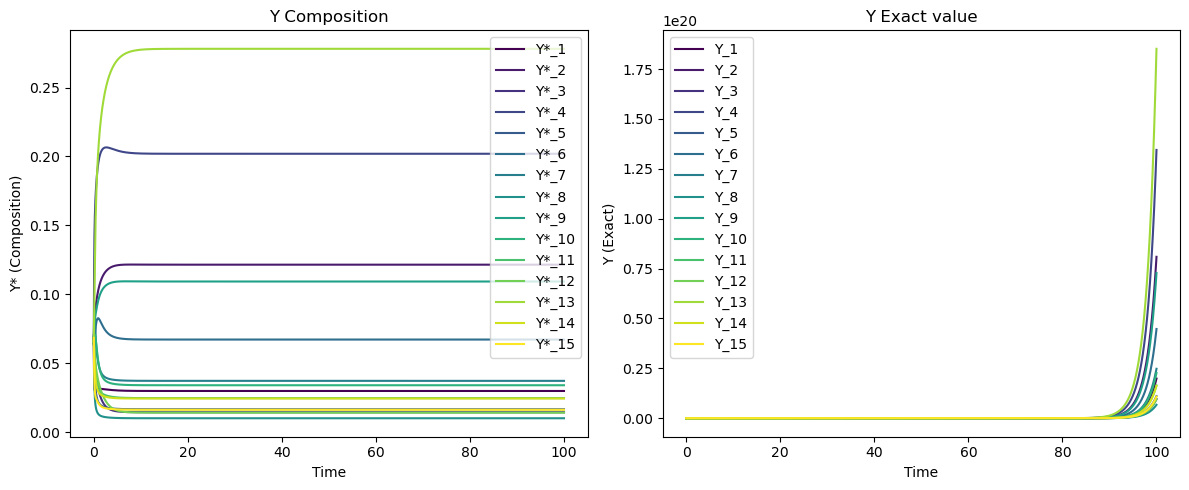

In [6]:
'''
Single network growth
'''
def main_example():
    # generate random networks
    N_X_raw, N_Y_raw, N_R_raw = 10, 15, 20
    Stot, N_X, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_X_raw, N_Y_raw, N_R_raw,
        diluted=False, ambiguity=False, autonomy=True
    )
    
    # construct kinetics
    X0, Y0, kf, kr, kd, mu_X_actual,  mu_0_Y, DeltaG0 = Construct_Kinetics(
        N_X, N_Y, N_R, S_plus, S_minus, degradation=False
    )
    print("Initial X0:", X0)
    print("Initial Y0:", Y0)
    print("kf:", np.round(kf, 3))
    print("kr:", np.round(kr, 3))
    print("kd:", kd if kd is not None else "None")
    print("DeltaG0:", np.round(DeltaG0, 3), "\n")

    # simulating
    dt = 1e-3
    n_steps = 100000
    t_eval, Ystar_traj, Yabs_traj, mus, N_traj = Solve_Scaled_System(
        S_minus, S_plus, X0, Y0, N_X, N_Y, N_R,
        kf, kr, kd, law="MA", dt=dt, n_steps=n_steps
    )

    # long-term growth rate λ
    lambda_est = compute_long_term_growth_rate(mus, last_n=100)
    print(f"Estimated long-term growth rate λ ≈ {lambda_est:.5f}\n")

    S_plus_trim = S_plus[N_X:, :]
    S_minus_trim = S_minus[N_X:, :]
    
    # mgf

    # algo1.growthRateGraph，max_steps/time_limit
    _, db_alpha, *_ = algo1.growthRateGraph(
        S_plus_trim, S_minus_trim,
        max_steps=1000, time_limit_iteration=100
    )
    
    mgf = db_alpha  

    # von-neumann growth factor
    vn_alpha, vn_beta = compute_von_neumann_alpha_beta(
    S_plus_trim, S_minus_trim)

    print(f" mgf = {mgf:.5f}; Von-neumann alpha = {vn_alpha:.5f}; Von-neumann beta = {vn_beta:.5f}   λ = {lambda_est:.5f}")

    # plot Y* vs time, exact Y vs time -----
    plt.figure(figsize=(12, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, N_Y))

    plt.subplot(1, 2, 1)
    for i in range(N_Y):
        plt.plot(t_eval, Ystar_traj[i, :], label=f"Y*_{i+1}", color=colors[i])
    plt.xlabel("Time")
    plt.ylabel("Y* (Composition)")
    plt.title("Y Composition")
    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(N_Y):
        plt.plot(t_eval, Yabs_traj[i, :], label=f"Y_{i+1}", color=colors[i])
    plt.xlabel("Time")
    plt.ylabel("Y (Exact)")
    plt.title("Y Exact value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# run
if __name__ == "__main__":
    main_example()

In [7]:
'''
Stoichometric autocatalytic and dynamic growth
'''

def main_example():

    target_num = 100
    
    # storage
    alpha_list = []
    beta_list = []
    lambda_list = []
    
    attempts = 0       
    successes = 0       
    
    # number of trail
    while successes < target_num and attempts < 2500:
        attempts += 1
        
        # Random networks
        Stot, N_X, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_X_raw=random.randint(3, 6),
        N_Y_raw=random.randint(3, 6),
        N_R_raw=random.randint(5, 10),
            diluted=False, ambiguity=False, autonomy=True
        )
        
        # Check autonomy condition
        S_plus_trim = S_plus[N_X:, :]
        S_minus_trim = S_minus[N_X:, :]
        _, _, auto = aux.checkAutonomy(S_minus_trim, S_plus_trim)
        if not auto:
            continue
        
        # von Neumann growth factor α, β
        try:
            alpha, beta = compute_von_neumann_alpha_beta(S_plus_trim, S_minus_trim)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue
        
        # Kinetics
        X0, Y0, kf, kr, kd, mu_X_actual, DeltaG0 = Construct_Kinetics(
            N_X, N_Y, N_R, S_plus, S_minus, degradation=False
        )
        
        # Simulation
        dt = 1e-3
        n_steps = 100000
        t_eval, Ystar_traj, Yabs_traj, mus, N_traj = Solve_Scaled_System(
            S_minus, S_plus, X0, Y0, N_X, N_Y, N_R,
            kf, kr, kd, law="MA", dt=dt, n_steps=n_steps
        )
        
        # long-term growth rate λ
        lambda_est = compute_long_term_growth_rate(mus, last_n=100)
        
        # 存储
        alpha_list.append(alpha)
        beta_list.append(beta)
        lambda_list.append(lambda_est)
        successes += 1
        
        print(f"【{successes}/{target_num}】  α = {alpha:.5f},  β = {beta:.5f},  λ = {lambda_est:.5f}")
    
    # check loop

        print(f"collect {successes} effective (α, β, λ), end")

    # plot von Neumann growth factor vs long-term growth rate
    plt.figure(figsize=(7, 6))
    
    # y=x reference line
    all_vals = alpha_list + beta_list + lambda_list
    vmin = min(all_vals) * 0.9
    vmax = max(all_vals) * 1.1
    xs = np.linspace(vmin, vmax, 100)
    plt.plot(xs, xs, linestyle='--', color='gray', linewidth=1, label='y = x')
    
    # for every sample (α, β, λ): if α≈β， plot a dot; other wise vertical line
    for α, β, λ in zip(alpha_list, beta_list, lambda_list):
        if abs(α - β) < 1e-6:
            # α ≈ β
            plt.scatter(λ, α, color='C0', edgecolors='k', s=40)
        else:
            # α != β, [min(α,β), max(α,β)] at x = λ
            lo = min(α, β)
            hi = max(α, β)
            plt.vlines(x=λ, ymin=lo, ymax=hi, color='C1', linewidth=2)
            # Also mark a small point at both ends
            plt.scatter([λ, λ], [lo, hi], color='C1', edgecolors='k', s=30)
    
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("von Neumann growth factor (α or [α,β])", fontsize=12)
    plt.title("von Neumann growth factor vs Long-term growth rate λ", fontsize=14)
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main_example()



Matrix Stot:
   1  2  3  4  5
1  0  0  0 -1  0
2  0  1 -1  0  0
3  0  0  0  1  0
4 -1  1  1  1  0
5  0 -1  1  0 -2
6  1  0 -1 -1  1

S_plus:
   1  2  3  4  5
1  0  0  0  0  0
2  0  1  0  0  0
3  0  0  0  1  0
4  0  1  1  1  0
5  0  0  1  0  0
6  1  0  0  0  1

S_minus:
   1  2  3  4  5
1  0  0  0  1  0
2  0  0  1  0  0
3  0  0  0  0  0
4  1  0  0  0  0
5  0  1  0  0  2
6  0  0  1  1  0
NX = 3
NY = 3
NR = 5


ValueError: too many values to unpack (expected 7)